# FIT3163 Data Analysis Report

Presented by: MDS12\
Team members: Satoshi Kashima, Shosuke Asano, Winnie Ooi Yun Ting

## 1. Introduction
Our dataset comprises images affected by sand dust, with separate sets for training and testing. Analyzing these images is essential to comprehend the dataset thoroughly. The data is pivotal in model construction as we base our model on the insights gained from these images. Furthermore, it's worth noting that the quality of our model is significantly influenced by the characteristics of these images, as they form the basis for our model's performance. This comprehensive analysis serves as the cornerstone for constructing a robust deep learning model capable of image restoration.

## 2. Data Cleaning and Preparation

### Data Collection
For the sand dust images data, we obtained two types of dataset. The first dataset contains the sand dust images together with the ground truth images as well. This dataset is provided to us by our supervisor as we couldn’t find the dataset with the ground truth online. The second type of datasets contains sand dust images only without any ground truth data. This dataset is found online from research papers such as on sand dust image enhancement (Park & Eom, 2021) that used the same dataset for their research as well. There are multiple other datasets used by different researchers obtained online through the research paper.

For this data analysis report, we're just going to analyse the first type of dataset with sand dust images and the ground truth for simplicity.

### Data Pre-processing
Before we start to analyse the dataset, we load the dataset into the Jupyter Notebook first to visualise them. After visualisation, we would perform certain data cleaning so it's easier for us to analyse later on.

In [5]:
# import libraries to be used
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import os
import random
from tqdm import tqdm

In [6]:
# import libraries to be used
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn import svm

## Loading Data

In [7]:
def load_images_in_a_directory(directory_path):
    images = []
    print(os.listdir(directory_path))
    for filename in os.listdir(directory_path):
        if filename.endswith("png") or filename.endswith("jpg"):
            image_path = os.path.join(directory_path, filename)
            image = Image.open(image_path)
            images.append(image)
    
    return images

In [8]:
os.listdir("SIE_Dataset/Real_world_images")

['Blowing_sand', 'Floating_dust', 'Sandstorm', 'Strong_sandstorm']

In [9]:
# loading ground truth images
path = "SIE_Dataset/Synthetic_images/Ground_truth"
gt_images = load_images_in_a_directory(path)

# loading corrupted images
path = "SIE_Dataset/Synthetic_images/Sand_dust_images"
dust_images = load_images_in_a_directory(path)

['001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg', '006.jpg', '007.jpg', '008.jpg', '009.jpg', '010.jpg', '011.jpg', '012.jpg', '013.jpg', '014.jpg', '015.jpg', '016.jpg', '017.jpg', '018.jpg', '019.jpg', '020.jpg', '021.jpg', '022.jpg', '023.jpg', '024.jpg', '025.jpg', '026.jpg', '027.jpg', '028.jpg', '029.jpg', '030.jpg', '031.jpg', '032.jpg', '033.jpg', '034.jpg', '035.jpg', '036.jpg', '037.jpg', '038.jpg', '039.jpg', '040.jpg', '041.jpg', '042.jpg', '043.jpg', '044.jpg', '045.jpg', '046.jpg', '047.jpg', '048.jpg', '049.jpg', '050.jpg', '051.jpg', '052.jpg', '053.jpg', '054.jpg', '055.jpg', '056.jpg', '057.jpg', '058.jpg', '059.jpg', '060.jpg', '061.jpg', '062.jpg', '063.jpg', '064.jpg', '065.jpg', '066.jpg', '067.jpg', '068.jpg', '069.jpg', '070.jpg', '071.jpg', '072.jpg', '073.jpg', '074.jpg', '075.jpg', '076.jpg', '077.jpg', '078.jpg', '079.jpg', '080.jpg', '081.jpg', '082.jpg', '083.jpg', '084.jpg', '085.jpg', '086.jpg', '087.jpg', '088.jpg', '089.jpg', '090.jpg', '091.jpg'

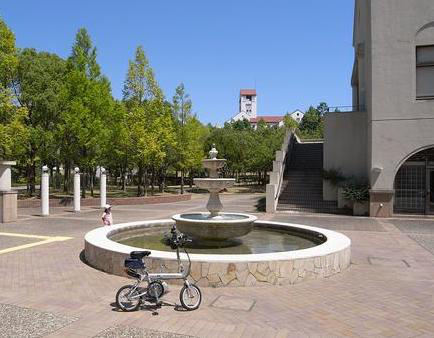

In [10]:
gt_images[0]

In [11]:
len(gt_images) == len(dust_images)

True

We found out that there are the same number of sand dust images and the ground truth images, meaning each of them has a matching pair.

In [12]:
len(gt_images)

500

There are 500 sand dust images and 500 corresponding ground truth images in total.

## Visualizing Raw Images

We visualize the raw images to see how they would look like and if there are any preprocessing steps to be done to counter for the limitations or biases found in the dataset before using it for analysis.

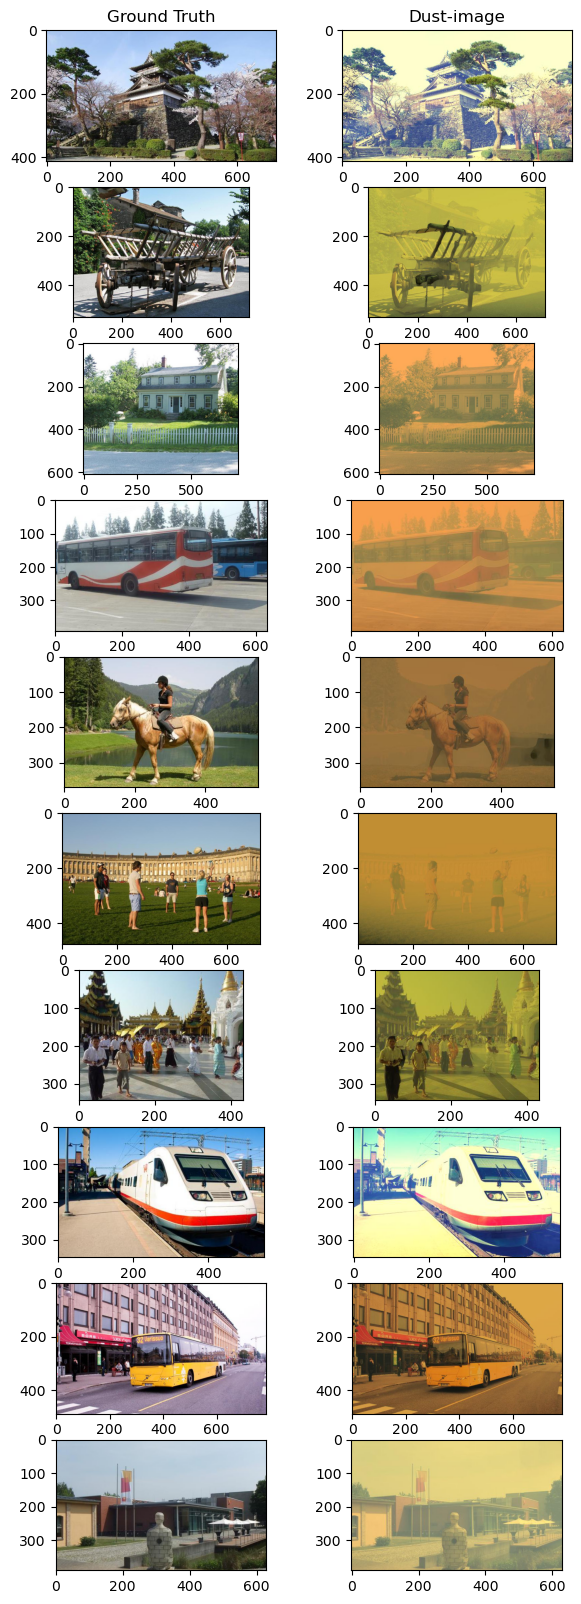

In [13]:
np.random.seed(123)
random_img_indices = np.random.randint(0, len(gt_images), size=(10, ))

fig = plt.figure(figsize=(7, 20))

for i in range(1, 11):
    ax1 = fig.add_subplot(10, 2, 2*i-1)
    ax1.imshow(gt_images[random_img_indices[i-1]])
    ax2 = fig.add_subplot(10, 2, 2*i)
    ax2.imshow(dust_images[random_img_indices[i-1]])
    
    if i == 1:
        ax1.set_title("Ground Truth")
        ax2.set_title("Dust-image")

We visualise 5 ground truth and corrupted images each. We found that the images have different sizes. We will ensure that all images have the same shape to be analysed and fed into the deep learning model later so we would perform resizing of images below.

## Resizing Images

We find the most frequent image size and visualise it using the 3d bar plot below.

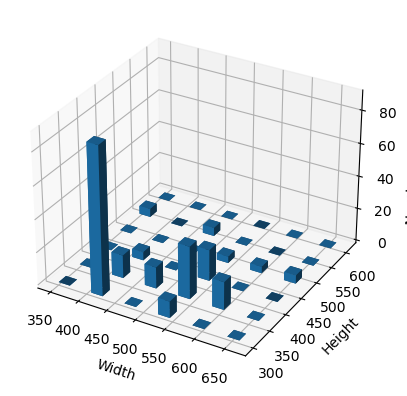

In [14]:
widths = [image.width for image in gt_images]
heights = [image.height for image in gt_images]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(widths, heights, bins=6, range=[[350, 700], [300, 650]])

# position of bins
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# size of bars
dx = dy = 20 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_zlabel("Number of Images")

plt.show()

In [15]:
i_max, j_max = np.unravel_index(hist.argmax(axis=None), hist.shape)
most_frequent_width = (xedges[i_max] + xedges[i_max+1]) / 2
most_frequent_height = (yedges[j_max] + yedges[j_max+1]) / 2
print(f"The average width and height of most frequent images are: {most_frequent_width}, and {most_frequent_height}")

The average width and height of most frequent images are: 437.5, and 329.16666666666663


We see that a large portion of images have a shape of approximately 440 by 330. Therefore, we will crop images that are bigger than these width and height. Since we are not dealing with classification task, but rather removing noises from the images, we can crop different parts of images, with the same size.For smaller images, we will stretch first and then apply cropping.

In [16]:
def crop_image(image, w_threshold, h_threshold):
    assert image.width >= w_threshold and image.height >= h_threshold, "to crop, image size must be bigger than or equal to the threshold values"
    
    # choose top and right randomly -> bottom and left automallycally determined
    top = random.randint(0, image.height - h_threshold)  # inclusive
    left = random.randint(0, image.width - w_threshold)
    
    bottom = top + h_threshold
    right = left + w_threshold
    
    return image.crop((left, top, right, bottom))
    

def is_image_smaller_than_threshold(image, w_threshold, h_threshold) -> bool:
    return image.width < w_threshold or image.height < h_threshold

def stretch_image(image, w_threshold, h_threshold):
    aspect_ratio = h_threshold / w_threshold
    
    if h_threshold - image.height < 0:
        resize_based_on_width = True
    elif w_threshold - image.width < 0:
        resize_based_on_width = False
    else:
        # resize based on whichever the difference is smaller
        resize_based_on_width = np.argmin([w_threshold - image.width, h_threshold - image.height])
        
    if resize_based_on_width:
        new_w = w_threshold
        new_h = int(new_w * aspect_ratio)
    else:
        new_h = h_threshold
        new_w = int(new_h / aspect_ratio)
    
    return image.resize((new_w, new_h))

In [17]:
def resize_images(images, w_threshold, h_threshold):
    resized_images = []
    for image in tqdm(images):
        if is_image_smaller_than_threshold(image, w_threshold, h_threshold):
            image = stretch_image(image, w_threshold, h_threshold)
        
        new_image = crop_image(image, w_threshold, h_threshold)
        resized_images.append(new_image)
    
    return resized_images

In [18]:
W_THRESHOLD = 440
H_THRESHOLD = 330

# apply resizing to gt_images and dust images
resized_gt_images = resize_images(gt_images, W_THRESHOLD, H_THRESHOLD)
resized_dust_images = resize_images(dust_images, W_THRESHOLD, H_THRESHOLD)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 217.51it/s]


We check that all images have the size = 440*330

In [19]:
resized_gt_images

[<PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=440x330>,
 <PIL.Image.Image image mode=RGB size=44

## 3. Data Analysis and Clustering
After we preprocessed our data by resizing them to the same size, we proceed to the data analysis step. Data analysis is crucial as it enables us to identify the main characteristics of data and understand more about our data to find a suitable model and implementation for our dataset.

For analysis of our data, we will first convert our PIL images to Numpy arrays.

In [20]:
gt_arrays = []
dust_arrays = []

for image in resized_gt_images:
    gt_arrays.append(np.array(image))

for image in resized_dust_images:
    dust_arrays.append(np.array(image))

In [21]:
gt_arrays[0].shape

(330, 440, 3)

### Color Histogram Comparisons

We will first compare color histograms for ground-truth and sand dust images. Below are some functions used to create the plot.

In [22]:
def calculate_bin_centers(bins):
    bin_centers = []
    for i in range(len(bins)-1):
        bin_center = (bins[i] + bins[i+1]) / 2
        bin_centers.append(bin_center)
    return bin_centers

In [23]:
def plot_color_histogram(image_array):
    r_hist, r_edges = np.histogram(image_array[:, :, 0].flatten(), bins=80)
    g_hist, g_edges = np.histogram(image_array[:, :, 1].flatten(), bins=80)
    b_hist, b_edges = np.histogram(image_array[:, :, 2].flatten(), bins=80)

    plt.plot(calculate_bin_centers(r_edges), r_hist, color="red")
    plt.plot(calculate_bin_centers(g_edges), g_hist, color="green")
    plt.plot(calculate_bin_centers(b_edges), b_hist, color="blue")
    
def get_color_histogram_data(image_array):
    r_hist, r_edges = np.histogram(image_array[:, :, 0].flatten(), bins=80)
    g_hist, g_edges = np.histogram(image_array[:, :, 1].flatten(), bins=80)
    b_hist, b_edges = np.histogram(image_array[:, :, 2].flatten(), bins=80)

    return (r_hist, r_edges), (g_hist, g_edges), (b_hist, b_edges)

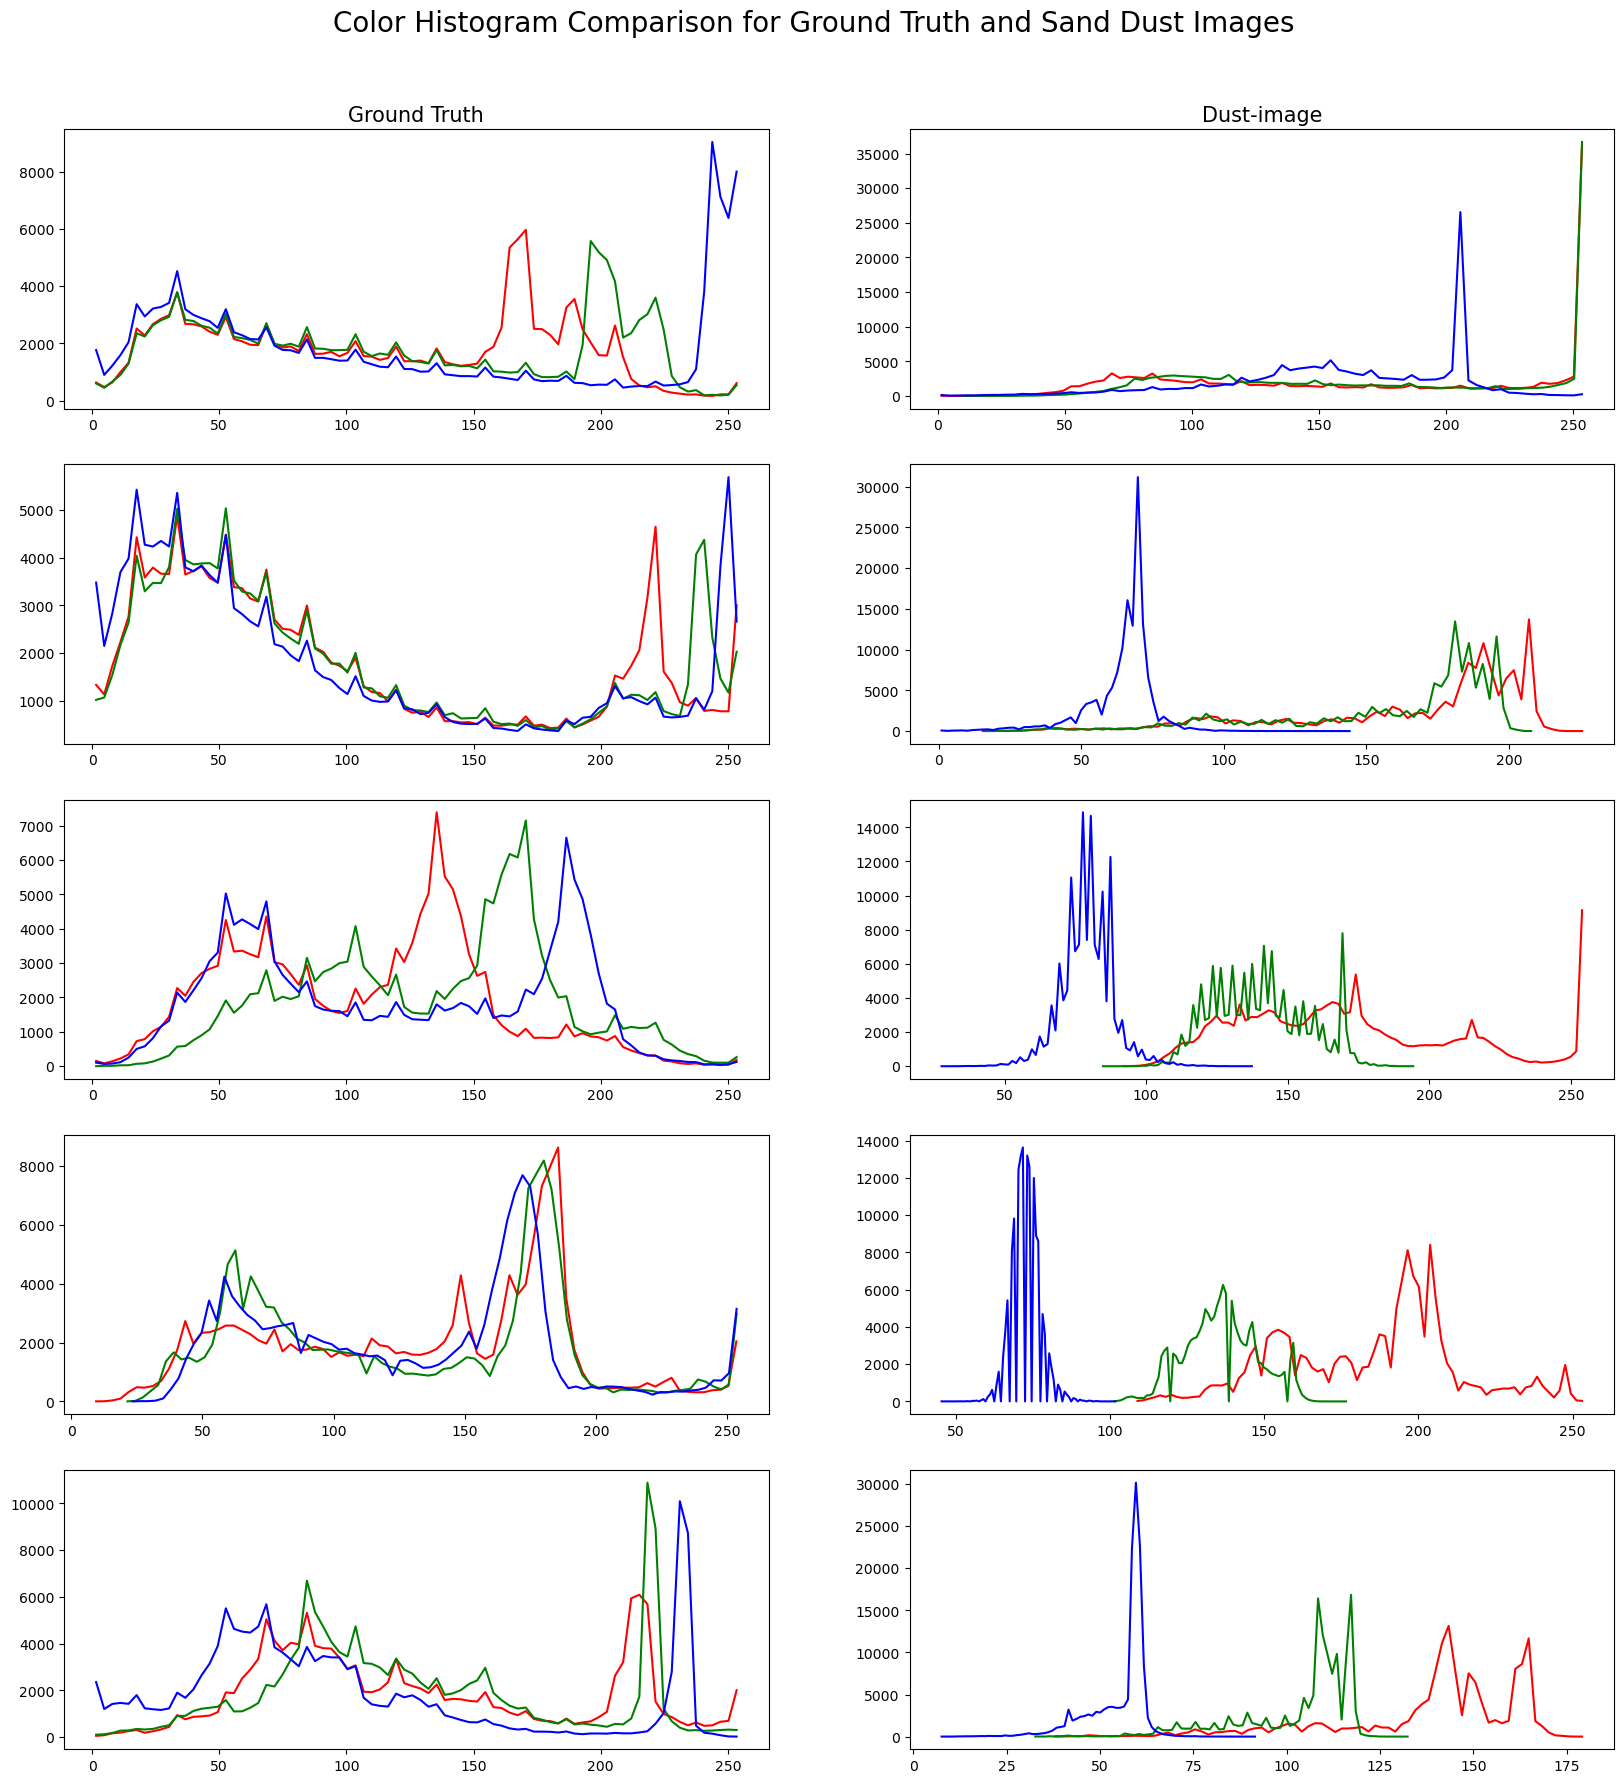

In [24]:
np.random.seed(123)
random_img_indices = np.random.randint(0, len(gt_images), size=(5, ))

fig = plt.figure(figsize=(20, 20))
fig.suptitle("Color Histogram Comparison for Ground Truth and Sand Dust Images", fontsize=20)
fig.subplots_adjust(top=0.92)

for i in range(1, 6):
    ax1 = fig.add_subplot(5, 2, 2*i-1)
    gt_image_array = gt_arrays[random_img_indices[i-1]]
    (r_hist, r_edges), (g_hist, g_edges), (b_hist, b_edges) = get_color_histogram_data(gt_image_array)
    ax1.plot(calculate_bin_centers(r_edges), r_hist, color="red")
    ax1.plot(calculate_bin_centers(g_edges), g_hist, color="green")
    ax1.plot(calculate_bin_centers(b_edges), b_hist, color="blue")
    
    
    ax2 = fig.add_subplot(5, 2, 2*i)
    dust_image_array = dust_arrays[random_img_indices[i-1]]
    (r_hist, r_edges), (g_hist, g_edges), (b_hist, b_edges) = get_color_histogram_data(dust_image_array)
    ax2.plot(calculate_bin_centers(r_edges), r_hist, color="red")
    ax2.plot(calculate_bin_centers(g_edges), g_hist, color="green")
    ax2.plot(calculate_bin_centers(b_edges), b_hist, color="blue")
    
    if i == 1:
        ax1.set_title("Ground Truth", fontsize=15)
        ax2.set_title("Dust-image", fontsize=15)

Each row corresponds to a randomly selected image. The left and right columns represent ground truth and sand dust images repectively. <br>Some insights:
- In the ground-truth normal images, we see that there often is a peak of blue curive at very large pixel value, appriximately at 250. This is caused by the fact that most images consist of the sky as background.
- Often times, the blue curve peak at a very large pixel value disappears in sand-dust images. In sand-dust images, blue curve peaks occur at much lower magnitudes. Instead, the red and green (especially red) distributions shift to the right. Since, sand dust is usually reddish to greenish, this tendency is reasonable.
- Curves for the sand-dust images are much sharper and fluctuates often. Compared to this, the curves for the ground-truth images are smoother. This difference arises from the fact that there are noises in sand dust images.
- For ground truth images, RGB curves often corrleate with each other (R curve is on top of G curve, and vice versa), while the peaks and center of distributions often do not match for sand dust images. In fact, for the last three images, the blue, green and red curves almost do not overlap with each other and even if they do, its amount is very small. Therefore, we can argue that the variance between RGB magnitudes are larger for sand dust images.

### k-Means Clustering and Support Vector Machine

We first create the feature matrix.

In [25]:
gt_arrays = np.array(gt_arrays)
dust_arrays = np.array(dust_arrays)

gt_rows = gt_arrays.reshape((gt_arrays.shape[0], -1))
dust_rows = dust_arrays.reshape((gt_arrays.shape[0], -1))
features = np.concatenate((gt_rows, dust_rows), axis=0)
labels = [0 for _ in range(500)] + [1 for _ in range(500)]

In [26]:
features.shape

(1000, 435600)

In [27]:
ss = StandardScaler()
standardized_features = ss.fit_transform(features)

pca = PCA(n_components=2)
pca_reduced_features = pca.fit_transform(standardized_features)

In [28]:
pca_reduced_features.shape

(1000, 2)

In [29]:
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(pca_reduced_features)

D:\anaconda\envs\fyp\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=2, n_init=10)

In [30]:
kmeans.cluster_centers_

array([[ 250.46421454,  -25.63797925],
       [-273.51949789,   27.9979606 ]])

In [31]:
confusion_matrix(labels, kmeans.labels_)

array([[276, 224],
       [246, 254]], dtype=int64)

In [32]:
def plot_kmeans_visualization(kmeans_, pca_reduced_features, labels):
    fig = plt.figure(figsize=(10, 10))

    # creating a mesh
    x_min, x_max = pca_reduced_features[:, 0].min() - 10, pca_reduced_features[:, 0].max() + 10
    y_min, y_max = pca_reduced_features[:, 1].min() - 10, pca_reduced_features[:, 1].max() + 10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 10), np.arange(y_min, y_max, 10))
    z = kmeans_.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)

    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(z, interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),aspect="auto",cmap=plt.cm.Paired,
    origin="lower",)

    ax.scatter(x=pca_reduced_features[:, 0], y=pca_reduced_features[:, 1], color=["red" if label== 0 else "blue" for label in labels])

    ax.scatter(x=kmeans_.cluster_centers_[:,0].flatten(), y=kmeans_.cluster_centers_[:,1].flatten(), marker="P", sizes=[400, 400], color="green")

    plt.show()

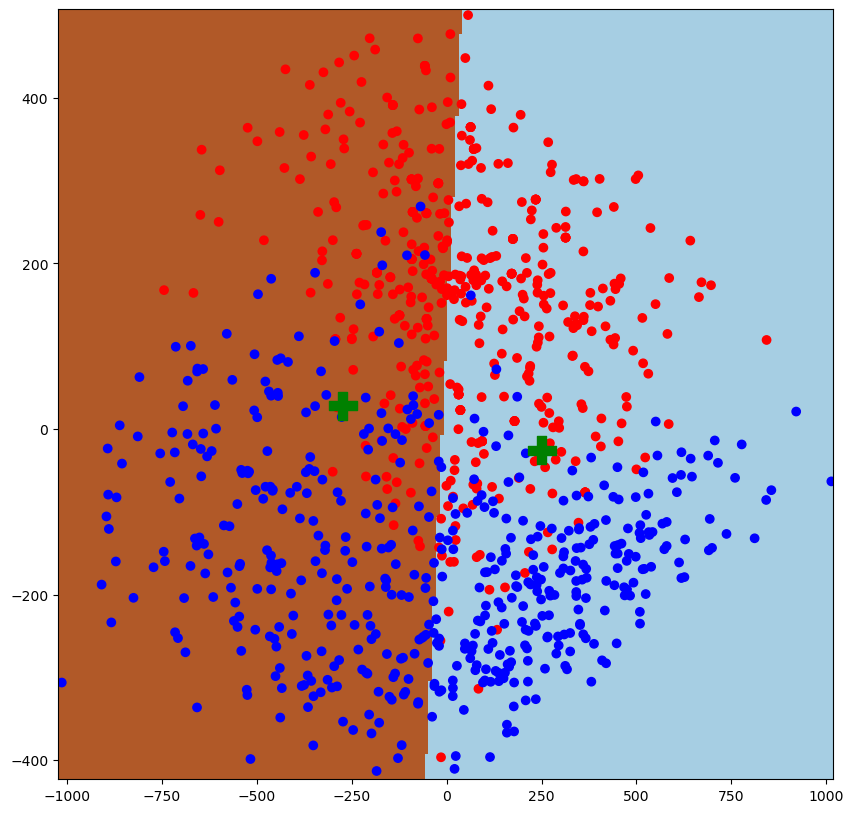

In [33]:
plot_kmeans_visualization(kmeans, pca_reduced_features, labels)

To separate the data points by the labels we already know, we can increase the number of centroids from 2 to 3.

In [34]:
kmeans_3clusters = KMeans(n_clusters=3, n_init=10)
kmeans_3clusters.fit(pca_reduced_features)

D:\anaconda\envs\fyp\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=3, n_init=10)

In [35]:
kmeans_3clusters.cluster_centers_

array([[ -53.56149849,  194.13269212],
       [-430.53015096, -136.26011002],
       [ 287.62708665,  -94.82521137]])

Now, we can visually see that the data points are clustered better. We can argue that the left and right clusters represents the sand dust images and the top clusters represents the ground truth images.

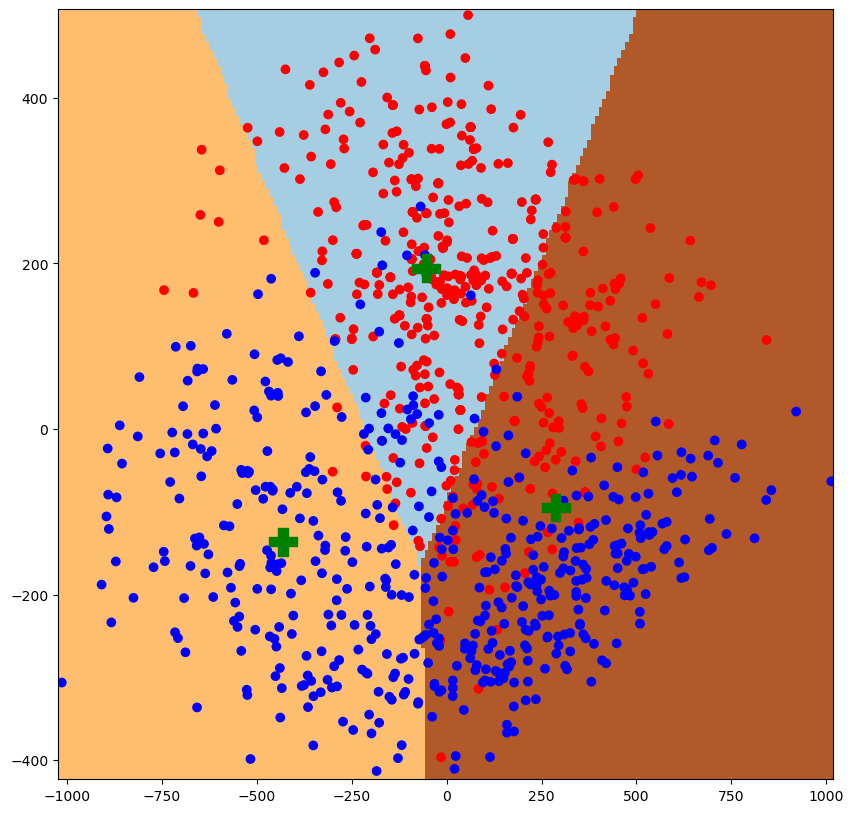

In [36]:
plot_kmeans_visualization(kmeans_3clusters, pca_reduced_features, labels)

To make the classification of the data points even clearer, we can use Support Vector Machine. Here, we do not separate our data into train and test dataset since our purpose is to roughly trace the trend of the datasets (therefore, overfitting is not a problem here). 

In [37]:
clf = svm.SVC()
clf.fit(pca_reduced_features, labels)

SVC()

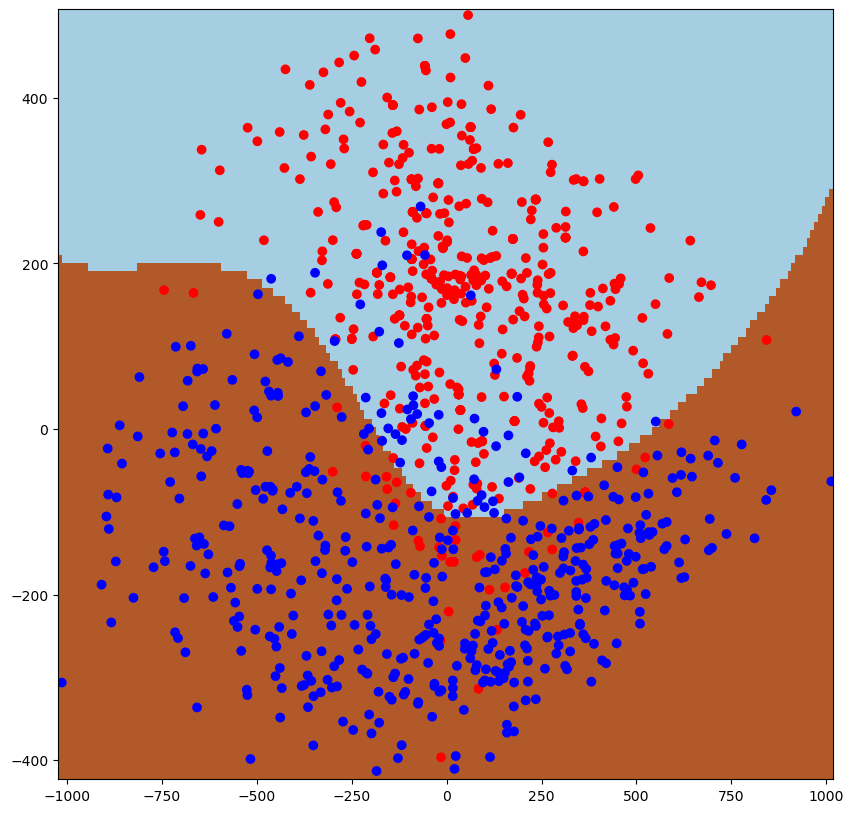

In [38]:
fig = plt.figure(figsize=(10, 10))

# creating a mesh
x_min, x_max = pca_reduced_features[:, 0].min() - 10, pca_reduced_features[:, 0].max() + 10
y_min, y_max = pca_reduced_features[:, 1].min() - 10, pca_reduced_features[:, 1].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, 10), np.arange(y_min, y_max, 10))
z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

ax = fig.add_subplot(1, 1, 1)
ax.imshow(z, interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower")

ax.scatter(x=pca_reduced_features[:, 0], y=pca_reduced_features[:, 1], color=["red" if label== 0 else "blue" for label in labels])

# ax.scatter(x=kmeans.cluster_centers_[:,0].flatten(), y=kmeans.cluster_centers_[:,1].flatten(), marker="P", sizes=[400, 400], color="green")

plt.show()

We see that the boundary curve follows somewhat similar to a quadratic curve. This matches with our visual understanding of the clusters. In general, we can argue that sand dust images have more variance compared to the natural images.

## 4. Results and Findings